<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/energy_gdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy and economic output

This notebook aims to show the link (if not causal relationship) between energy consumption (or production) and GDP output.

This notebook is coded in Python and relies on a few libraries (or packages), which we load below



In [1]:
import pandas as pd                      # This library is for data wrangling
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # This is another library for plots 
import warnings                          # This is to remove warning to keep output clean
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown

## Data
### Data sources

We need two types of data and hence resort to two sources:
- for **energy** production and consumption, we use data compiled by **BP**. While it is undeniably a corporate source, it is widely considered as reliable, especially for non renewable energies. For renewables, the post https://www.resilience.org/stories/2017-08-02/how-bp-is-minimizing-renewable-energy-in-its-statistical-review/ contends that the company purposefully minimizes the numbers. For our study, this will not be a major issue.
- for **economic data**, several sources are possible, including the **International Monetary Fund** and the **World Bank**, and we will work with the latter. Both provide country-level data up to 1980 and 1960, respectively.

### Energy data
**NOTE**: the dataset is quite large (250K+ rows), so the importation takes a few seconds.

In [2]:
url = 'https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/bp-stats-review-2021-consolidated-dataset-narrow-format.xlsx'
data_energy_sources = pd.read_excel(url) # Reads the online file 
data_energy_sources                      # Shows the result

,Country,Year,ISO3166_alpha3,ISO3166_numeric,Region,SubRegion,OPEC,EU,OECD,CIS,Var,Value
0,Algeria,1965,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
1,Algeria,1966,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
2,Algeria,1967,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
252913,Zimbabwe,2018,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.438812
252914,Zimbabwe,2019,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.645473
252915,Zimbabwe,2020,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.862927


**NOTE**: not all countries are present, since Afghanistan seems to be missing...   
One interesting column is the **Var**, which specifies which variable is produced. Let's have a look at the list.

In [3]:
data_energy_sources['Var'].unique().tolist() 

['wind_twh',
 'wind_mtoe',
 'wind_ej',
 'solar_twh',
 'solar_mtoe',
 'solar_ej',
 'renewables_mtoe',
 'renewables_ej',
 'ren_power_twh',
 'ren_power_mtoe',
 'ren_power_ej',
 'refthru_kbd',
 'refcap_kbd',
 'rareearths_kt',
 'primary_mtoe',
 'primary_gj_pc',
 'primary_ej',
 'oilreserves_bbl',
 'oilprod_ngl_kbd',
 'oilprod_mt',
 'oilprod_kbd',
 'oilprod_crudecond_kbd',
 'oilcons_mtoe',
 'oilcons_mt',
 'oilcons_kbd',
 'oilcons_ej',
 'nuclear_twh',
 'nuclear_mtoe',
 'nuclear_ej',
 'lithium_kt',
 'liqcons_kbd',
 'hydro_twh',
 'hydro_mtoe',
 'hydro_ej',
 'graphite_kt',
 'gasreserves_tcm',
 'gasprod_mtoe',
 'gasprod_ej',
 'gasprod_bcm',
 'gasprod_bcfd',
 'gascons_mtoe',
 'gascons_ej',
 'gascons_bcm',
 'gascons_bcfd',
 'ethanol_prod_pj',
 'ethanol_prod_ktoe',
 'ethanol_prod_kboed',
 'ethanol_prod_kbd',
 'ethanol_cons_pj',
 'ethanol_cons_ktoe',
 'ethanol_cons_kboed',
 'ethanol_cons_kbd',
 'electbyfuel_oil',
 'electbyfuel_gas',
 'electbyfuel_coal',
 'elect_twh',
 'cobalt_kt',
 'coalprod_mtoe',
 '

This is a looong list. We see that the suffixes tell the units in which the values are expressed.  
For instance, "ej" refers to **exajoule**, which is 10^18 joules while "pt" to **petajoule**, which is 10^15 joules.   
The joule is a classical unit used to quantify amounts of energy.

Since most categories are expressed in joules, we will keep these variables and discard the rest.

In [4]:
data_energy_sources = data_energy_sources[data_energy_sources['Var'].str.endswith('j')]
data_energy_sources

,Country,Year,ISO3166_alpha3,ISO3166_numeric,Region,SubRegion,OPEC,EU,OECD,CIS,Var,Value
10006,Algeria,1965,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_ej,0.000000
10007,Algeria,1966,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_ej,0.000000
10008,Algeria,1967,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_ej,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
245380,US,2018,USA,840.0,North America,North America,0.0,0.0,1.0,0.0,biodiesel_cons_pj,237.209821
245381,US,2019,USA,840.0,North America,North America,0.0,0.0,1.0,0.0,biodiesel_cons_pj,225.887978
245382,US,2020,USA,840.0,North America,North America,0.0,0.0,1.0,0.0,biodiesel_cons_pj,232.231787


For obvious **consistency** reasons, we need to put all joule type units at the same scale, which we choose to be the petajoule. Hence, we need to multiply the exajoule values by 1,000.

In [5]:
data_energy_sources['Scale'] = data_energy_sources['Var'].transform(lambda x: 1000 if x.endswith('ej') else 1) # Scale column  
data_energy_sources['Value'] = data_energy_sources['Value'] * data_energy_sources['Scale']                     # Adjusted value
data_energy_sources = data_energy_sources.loc[:, ['Country', 'Year', 'Region', 'Var', 'Value']]                # Keeping 5 columns
data_energy_sources

,Country,Year,Region,Var,Value
10006,Algeria,1965,Africa,wind_ej,0.000000
10007,Algeria,1966,Africa,wind_ej,0.000000
10008,Algeria,1967,Africa,wind_ej,0.000000
...,...,...,...,...,...
245380,US,2018,North America,biodiesel_cons_pj,237.209821
245381,US,2019,North America,biodiesel_cons_pj,225.887978
245382,US,2020,North America,biodiesel_cons_pj,232.231787


To further clean the **Var** columns, let's remove the suffixes.


In [6]:
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_ej'))
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_pj'))
data_energy_sources = data_energy_sources.rename(columns = {'Value' : 'Consumption'})  # Change name of column

Finally, let's limit the number of categories:

In [7]:
categories = ['wind',
              'solar',
              'renewables',
              'ren_power',
              'oilcons',
              'nuclear',
              'hydro',
              'gascons',
              'ethanol_cons',
              'coalcons',
              'biogeo',
              'biofuels_cons',
              'biodiesel_cons']
data_energy_sources = data_energy_sources[data_energy_sources['Var'].isin(categories)]
data_energy_sources

,Country,Year,Region,Var,Consumption
10006,Algeria,1965,Africa,wind,0.000000
10007,Algeria,1966,Africa,wind,0.000000
10008,Algeria,1967,Africa,wind,0.000000
...,...,...,...,...,...
245380,US,2018,North America,biodiesel_cons,237.209821
245381,US,2019,North America,biodiesel_cons,225.887978
245382,US,2020,North America,biodiesel_cons,232.231787


In order to obtain a particular value, we can **query** the dataframe as follows (for French nucelar energy beyond 2010 for instance).

In [8]:
data_energy_sources.query('Country == "France" & Year > 2010 & Var == "nuclear"')

,Country,Year,Region,Var,Consumption
120125,France,2011,Europe,nuclear,4127.156341
120126,France,2012,Europe,nuclear,3944.673818
120127,France,2013,Europe,nuclear,3905.048494
...,...,...,...,...,...
120132,France,2018,Europe,nuclear,3694.742528
120133,France,2019,Europe,nuclear,3556.940653
120134,France,2020,Europe,nuclear,3142.613545


If we want to perform first a macro analysis, we will only need the data for the whole world, so let's keep a separate object for this purpose.

In [9]:
data_energy_sources_global = data_energy_sources.query('Country == "Total World"')   # Filter on particular country/zone
data_energy_sources_global

,Country,Year,Region,Var,Consumption
14433,Total World,1965,NaN,wind,0.000000
14434,Total World,1966,NaN,wind,0.000000
14435,Total World,1967,NaN,wind,0.000000
...,...,...,...,...,...
245349,Total World,2018,NaN,biodiesel_cons,1388.504387
245350,Total World,2019,NaN,biodiesel_cons,1515.362928
245351,Total World,2020,NaN,biodiesel_cons,1527.845223


Before we move on to the GDP data, let's have a look a the relative importance of each category (worldwide).

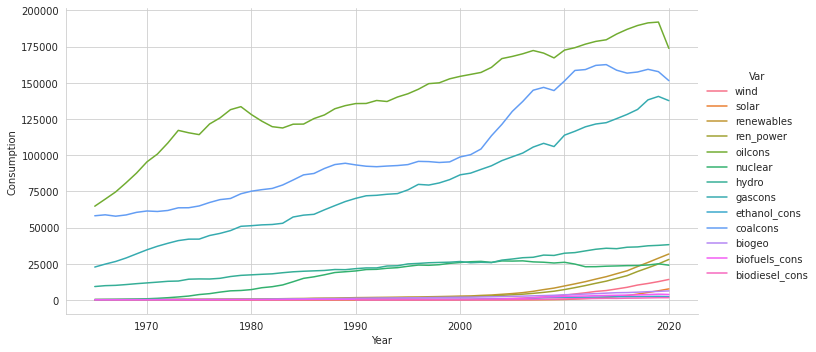

In [10]:
sns.set_style("whitegrid")
sns.relplot(
    data = data_energy_sources_global,   # Data source = the filtered data (other method)
    kind = "line",                       # Graph type = line
    x = "Year",                          # x-axis = Date column (of course!)
    y = "Consumption",                   # y-axis = the normalised Close column
    hue = "Var",                         # One color for each sector
    aspect = 2
)

To stack the values, we must reshape the data into a wide format.

In [11]:
data_energy_sources_global_plot = data_energy_sources_global.drop_duplicates(subset = ['Year', 'Var'])
data_energy_sources_global_plot = data_energy_sources_global_plot.pivot(index = ['Year'], 
                                                                        columns = 'Var', 
                                                                        values = "Consumption")
data_energy_sources_global_plot = data_energy_sources_global_plot.reset_index().fillna(0)
data_energy_sources_global_plot

Var,Year,biodiesel_cons,biofuels_cons,biogeo,coalcons,ethanol_cons,gascons,hydro,nuclear,oilcons,ren_power,renewables,solar,wind
0,1965,0.000000,32.507508,179.852321,58104.641832,0.000000,22693.676146,9231.979239,255.397242,64719.229929,179.852321,212.359829,0.000000,0.000000
1,1966,0.000000,33.155433,198.060069,58766.737854,0.000000,24727.660295,9838.170370,344.332903,69603.852100,198.060069,231.215502,0.000000,0.000000
2,1967,0.000000,33.781369,199.865707,57818.915036,0.000000,26546.541743,10057.426517,410.060140,74588.598448,199.865707,233.647076,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2018,1388.504387,3702.122284,5656.292888,159260.311158,2313.617898,138164.262163,37370.361804,24127.270371,191328.179584,22177.356211,25879.478483,5162.195372,11358.867951
54,2019,1515.362928,3957.077447,5911.430639,157639.143841,2441.714520,140541.848501,37688.955419,24929.971958,191889.526763,24864.190436,28821.268024,6310.654018,12642.105779
55,2020,1527.845223,3761.025870,6217.752589,151424.668918,2233.180647,137619.984020,38162.617348,23981.318529,173733.376076,27950.558823,31711.584460,7600.232346,14132.573888


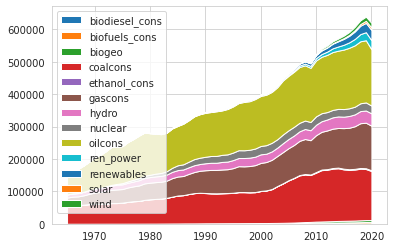

In [12]:
plt.stackplot(data_energy_sources_global_plot['Year'],
              data_energy_sources_global_plot.drop('Year', axis = 1).to_numpy().transpose(),
              labels = list(data_energy_sources_global_plot.drop('Year', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(10, 6)
plt.show()

Clearly, three main blocks emerge: oil, coal, and gas. Even if alternative sources are slightly underestimated, it is clear these three dominate worldwide energy consumption.

### Economic data
Now let's move on to the economic part of the data.   
We are interested in aggregate production, which we will proxy with **Gross Domestic Product** (GDP).    
We obtain the historical series from the API of the **World Bank**.

In [13]:
url = 'https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel'
data_gdp = pd.read_excel(url, skiprows = 3) 
# Putting the data in long format below
data_gdp = pd.wide_to_long(data_gdp.iloc[0:,0:65], 
                stubnames = [''], 
                i = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                j = 'Year').reset_index()
data_gdp = data_gdp.rename(columns = {'Country Name': 'Country', '': 'GDP'})
data_gdp = data_gdp.loc[ : , ['Country', 'Year', 'GDP']]
data_gdp

,Country,Year,GDP
0,Aruba,1960,NaN
1,Aruba,1961,NaN
2,Aruba,1962,NaN
...,...,...,...
16223,Zimbabwe,2018,1.952362e+10
16224,Zimbabwe,2019,1.693243e+10
16225,Zimbabwe,2020,1.676851e+10


**NOTE**: there is also a value "World" for the country in this dataset.

## Time-series visualization

To get a first feel at the data, let's have a look at the global trends.  
To do that, we must aggregate all energy values for the world into a **pivot table**.

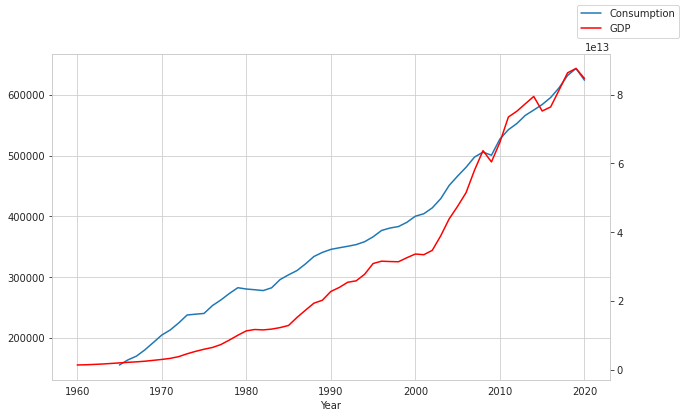

In [14]:
ax = data_energy_sources_global.pivot_table(values=['Consumption'],  # This creates the pivot table
                                       aggfunc='sum', 
                                       index=['Country','Year']).reset_index().plot(x = "Year", 
                                                                                    y = "Consumption", 
                                                                                    legend = False) 
# This plots
ax2 = ax.twinx()
data_gdp.query('Country == "World"').plot(x = "Year", y = "GDP", ax = ax2, legend = False, color = "r")
ax.figure.legend()
plt.grid()
plt.show()
plt.rcParams["figure.figsize"]=(10, 6)

The left axis pertains to energy value in light blue in exajoules while the right axis relates to the global GDP (in red).  
The trends are quite similar...

## Relationships at a granular level

Let us now see how energy consumption relate to economic output at a more granular level.  
To do so, we will need to merge the two sources of data.   
In order to include the most important countries, we must make sure they have the same name in both datasets (e.g. "*US*" in the energy data versus "*United States*" in the economics data - though there is strangely no issue for the UK). 

In [15]:
data_merged = pd.merge(data_energy_sources.replace("US", "United States"),
                       data_gdp, on = ['Year', 'Country'])
data_merged

,Country,Year,Region,Var,Consumption,GDP
0,Algeria,1965,Africa,wind,0.000000,3.136259e+09
1,Algeria,1965,Africa,solar,0.000000,3.136259e+09
2,Algeria,1965,Africa,renewables,0.000000,3.136259e+09
...,...,...,...,...,...,...
41479,Vietnam,2020,Asia Pacific,coalcons,2101.594479,2.711584e+11
41480,Vietnam,2020,Asia Pacific,biogeo,0.003637,2.711584e+11
41481,Vietnam,2020,Asia Pacific,biofuels_cons,-0.000003,2.711584e+11


We can now use scatterplot to reveal the links between GDP and energy values.   
Given the discrepancies across countries, we use a log-log scale below.  
We start with **oil consumption** below.

Text(0.5, 1.0, 'GDP and oil consumption')

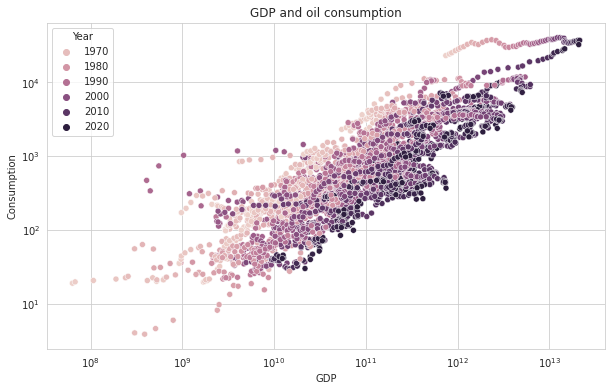

In [16]:
sns.scatterplot(data = data_merged.query('Var =="oilcons"'), 
                x = 'GDP', 
                y = 'Consumption',
                hue = 'Year')
plt.xscale('log')
plt.yscale('log')
plt.title('GDP and oil consumption')

In the graph above, each point is a pair (Country, Year) and the year is coded with colors, so that we can track evolutions.  
The link between the two variables is strong, almost linear.  
The light colors on top and dark colors at the bottom show that, recently, we were able to generate more GDP with similar levels of energy consumption: we have gained efficiency and productivity.    
The little snake at the top right of the plot is the trajectory of the **United States**.

(1, 100000)

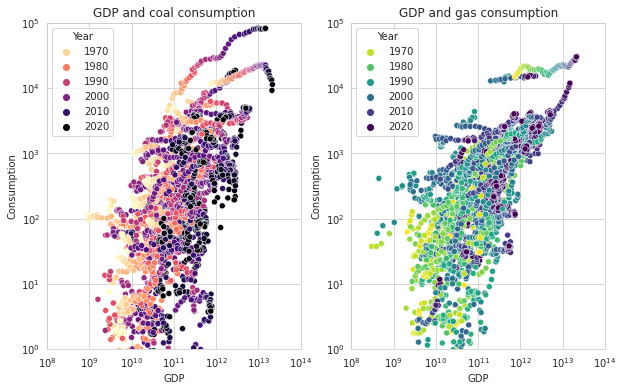

In [17]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(ax = ax[0],
                data = data_merged.query('Var =="coalcons"'), 
                x = 'GDP', 
                y = 'Consumption',
                hue = 'Year',
                palette = 'magma_r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('GDP and coal consumption')
ax[0].set_xlim(10**8,10**14)
ax[0].set_ylim(1,10**5)

sns.scatterplot(ax = ax[1],
                data = data_merged.query('Var =="gascons"'), 
                x = 'GDP', 
                y = 'Consumption',
                hue = 'Year',
                palette = 'viridis_r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('GDP and gas consumption')
ax[1].set_xlim(10**8,10**14)
ax[1].set_ylim(1,10**5)

For coal and gas, the link is also positive, but the correlation seems a bit weaker.

How about for nuclear energy?

(1, 10000)

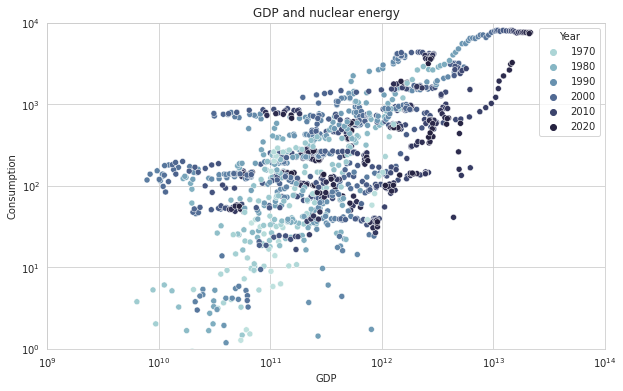

In [18]:
sns.scatterplot(data = data_merged.query('Var =="nuclear"'), 
                x = 'GDP', 
                y = 'Consumption',
                hue = 'Year',
                palette = 'ch:start=.15,rot=-.3')
plt.xscale('log')
plt.yscale('log')
plt.title('GDP and nuclear energy')
plt.xlim(10**9, 10**14)
plt.ylim(1, 10**4)

Again, more energy relates to larger GDP, and vice-versa.  
Note that there is no causality link shown in the data, it is only correlation.  
However, from a purely physical standpoint, in order to produce more, it seems reasonable to assume that we need to consume more energy. Productivity gains are only observed over long time scales.

Now let's have another look at the data, by aggregating values at the regional level. To do so, we need to compute a new pivot table.

(1000, 1000000)

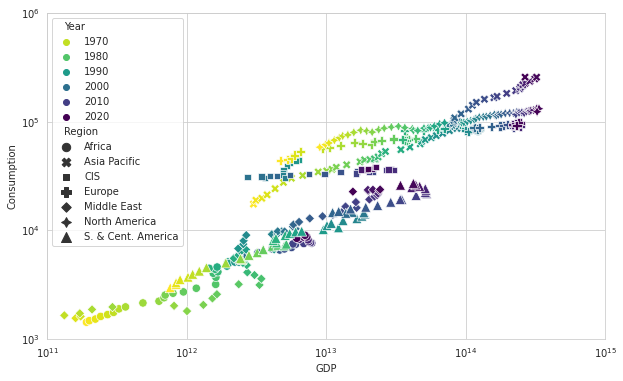

In [19]:
sns.scatterplot(data = data_merged.pivot_table(values=['Consumption', 'GDP'],  # This creates the pivot table
                                               aggfunc='sum', 
                                               index=['Region','Year']).reset_index(), 
                x = 'GDP', 
                y = 'Consumption',
                style = 'Region',
                hue = 'Year',
                size = 'Region',
                palette = 'viridis_r',
                sizes = [70,75,80,85,90,95,100])
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**11, 10**15)
plt.ylim(10**3, 10**6)

Thanks to the shapes, we are able to track the evolution of each region.  
**CIS** is the Commonwealth of Independent States, i.e., the former USSR.  
It is the only example of a region that increases its GDP with almost constant energy consumption.   
In Europe, the increase is small, in North America,  bit steeper, and in Asia, quite pronounced. 

## Conclusion

**In short**: energy and economic output are closely linked.  
Differences exist depending on *regions* and *energy* types, but all economies require some form of energetic input in order to function. 